# Anja Bikeshare submission

---

## Imports

In [5]:
import pandas as pd
import numpy as np
import math

from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

import seaborn as sns
import matplotlib.pyplot as plt

from Bikes_fe import fe_train, fe_test, prediction_to_csv #custom functions

## Get Data

In [6]:
train = 'data/bike-sharing-demand/train.csv'
df = pd.read_csv(train, parse_dates=True, index_col = 0)
df.head(3)
df.replace()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


## Train test split

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
Xtrain = df.drop(columns=['casual','registered','count'])
ytrain = df['count']

In [20]:
Xtrain_train, Xtrain_test, ytrain_train, ytrain_test = train_test_split(Xtrain, ytrain, random_state=20)
Xtrain.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0


## Feature Engineer

method fe_train from Bikes_fe.py splits df into Xtrain_train, Xtrain_test, ytrain_train, ytrain_test. Where Xtrain without columns "casual", "registered", "count", and ytrain is target column "count" = "casual" + "registered"

Idea for later: predict "casual" and "registered" separately and add up for "count". However, for the moment stay with target column "count".

In [10]:
Xtrain_train_fe = fe_train(Xtrain_train)
Xtrain_train_fe

,sin_time,cos_time,temp,windspeed
datetime,,,,
2012-03-12 19:00:00,-0.965926,0.258819,0.360462,0.273294
2012-01-09 09:00:00,0.707107,-0.707107,-1.430468,-1.570072
2011-08-15 22:00:00,-0.500000,0.866025,0.887207,0.518637
2011-11-19 13:00:00,-0.258819,-0.965926,-0.376980,0.764803
2012-05-14 20:00:00,-0.866025,0.500000,0.465811,0.027128
...,...,...,...,...
2012-10-05 05:00:00,0.965926,0.258819,0.149765,-1.570072
2012-04-12 21:00:00,-0.707107,0.707107,-0.376980,-0.464382
2012-05-07 08:00:00,0.866025,-0.500000,0.044416,0.027128


In [11]:
stunden = pd.DataFrame()
stunden['sin_time'] = np.sin(2*np.pi*df.index.hour.unique()/24)
stunden['cos_time'] = np.cos(2*np.pi*df.index.hour.unique()/24)

stunden

,sin_time,cos_time
0,0.000000e+00,1.000000e+00
1,2.588190e-01,9.659258e-01
2,5.000000e-01,8.660254e-01
3,7.071068e-01,7.071068e-01
4,8.660254e-01,5.000000e-01
5,9.659258e-01,2.588190e-01
6,1.000000e+00,6.123234e-17
7,9.659258e-01,-2.588190e-01
8,8.660254e-01,-5.000000e-01
9,7.071068e-01,-7.071068e-01


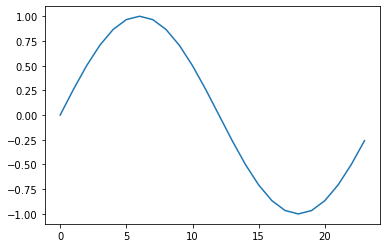

In [12]:
stunden.sin_time.plot()

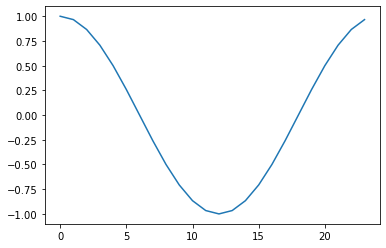

In [13]:
stunden.cos_time.plot()

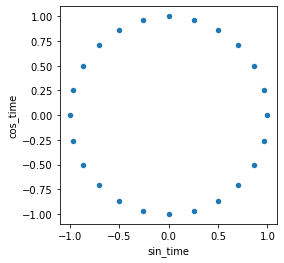

In [14]:
stunden.plot.scatter('sin_time','cos_time').set_aspect('equal')

## Train a model

In [46]:
# Create a pipeline
m = Pipeline([
    ('poly_features', PolynomialFeatures(degree=8, include_bias=False)),
    ('linear_regression', LinearRegression())
])

In [47]:
m.fit(Xtrain_train_fe,ytrain_train)

Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=8, include_bias=False)),
                ('linear_regression', LinearRegression())])

In [48]:
m.score(Xtrain_train_fe,ytrain_train)

0.6481401087844342

In [49]:
ytrain_pred = m.predict(Xtrain_train_fe)

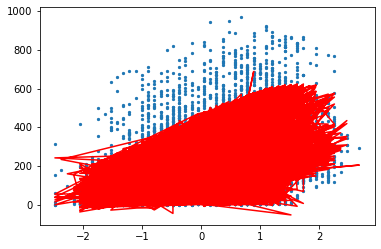

In [50]:
plt.scatter(Xtrain_train_fe['temp'], ytrain_train, s = 5)
plt.plot(Xtrain_train_fe['temp'], ytrain_pred, c = 'red')

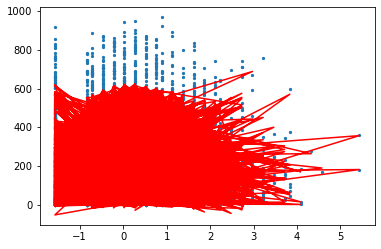

In [51]:
plt.scatter(Xtrain_train_fe['windspeed'], ytrain_train, s = 5)
plt.plot(Xtrain_train_fe['windspeed'], ytrain_pred, c = 'red')

## Cross validation

In [53]:
Xtrain_train_fe

,sin_time,cos_time,temp,windspeed
datetime,,,,
2012-03-12 19:00:00,-0.965926,0.258819,0.360462,0.273294
2012-01-09 09:00:00,0.707107,-0.707107,-1.430468,-1.570072
2011-08-15 22:00:00,-0.500000,0.866025,0.887207,0.518637
2011-11-19 13:00:00,-0.258819,-0.965926,-0.376980,0.764803
2012-05-14 20:00:00,-0.866025,0.500000,0.465811,0.027128
...,...,...,...,...
2012-10-05 05:00:00,0.965926,0.258819,0.149765,-1.570072
2012-04-12 21:00:00,-0.707107,0.707107,-0.376980,-0.464382
2012-05-07 08:00:00,0.866025,-0.500000,0.044416,0.027128


In [54]:
ytrain_train

datetime
2012-03-12 19:00:00    446
2012-01-09 09:00:00    197
2011-08-15 22:00:00     98
2011-11-19 13:00:00    363
2012-05-14 20:00:00    189
                      ... 
2012-10-05 05:00:00     41
2012-04-12 21:00:00    187
2012-05-07 08:00:00    639
2011-10-14 00:00:00     39
2012-12-12 20:00:00    268
Name: count, Length: 8164, dtype: int64

In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [73]:
cross_val_accuracy = cross_val_score(estimator = m
                   , X=Xtrain_train_fe
                   , y=ytrain_train
                   , cv=5
                   , scoring=('r2'))

In [74]:
cross_val_accuracy

array([ 0.61148542,  0.37358535,  0.55505604, -0.43026088,  0.52414663])

In [75]:
cross_val_accuracy.mean()

0.3268025123351023

## Test on unseen data

In [48]:
test = 'data/bike-sharing-demand/test.csv'
df2 = pd.read_csv(test, parse_dates=True, index_col = 0)

In [49]:
Xtest = fe_test(df2)
Xtest

,sin_time,cos_time,temp,windspeed
datetime,,,,
2011-01-20 00:00:00,0.000000,1.000000,-1.235966,1.620888
2011-01-20 01:00:00,0.258819,0.965926,-1.235966,-1.531139
2011-01-20 02:00:00,0.500000,0.866025,-1.235966,-1.531139
2011-01-20 03:00:00,0.707107,0.707107,-1.235966,-0.197558
2011-01-20 04:00:00,0.866025,0.500000,-1.235966,-0.197558
...,...,...,...,...
2012-12-31 19:00:00,-0.965926,0.258819,-1.235966,-0.197558
2012-12-31 20:00:00,-0.866025,0.500000,-1.235966,-0.197558
2012-12-31 21:00:00,-0.707107,0.707107,-1.235966,-0.197558


## Submit to kaggle

In [50]:
prediction_to_csv(Xtest,m)

In [51]:
!kaggle competitions submit -c bike-sharing-demand -f /Users/anja.jesierski/Spiced_Academy_Data_Science/a-star-anise-student-code/week_03/data/bike-sharing-demand/bikeshare_submission.csv -m "Thursday evening linear regression including hours, temp, and windspeed"

100%|████████████████████████████████████████| 243k/243k [00:03<00:00, 74.9kB/s]
Successfully submitted to Bike Sharing Demand